# Example GEV Analysis with Confidence Intervals

Matthew Walker, Leroy Bird, [Kanute](kanute.com).  2021-11-12.

In part two of this two-part series, we use artificial normally-distributed data to demonstrate how to fit a [Generalized Extreme Value (GEV) distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution) and then produce plots that indicate the confidence we should have in that GEV fit, along with confidence intervals for values for a given return period.

We use a GEV-parameterised bootstrap method (Kyselý 2008).

For the latest version of this tutorial, please see [the GitHub repository](https://github.com/kanute-climate/gev-tutorial). 

---

Kyselý, J. (2008). A Cautionary Note on the Use of Nonparametric Bootstrap for Estimating Uncertainties in Extreme-Value Models, Journal of Applied Meteorology and Climatology, 47(12), 3236-3251. Retrieved Nov 4, 2021, from https://journals.ametsoc.org/view/journals/apme/47/12/2008jamc1763.1.xml

In [1]:
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

rng = np.random.default_rng()

## The "True" Value

We first create a very large artificial dataset of normally-distributed values.  This dataset will be considered the source for later subsets and as such this very large dataset contains the "true" value.

This step is not normally a part of a GEV analysis but is included here so that, at the end, we can judge the "coverage" of our confidence intervals (whether, for example, our 95% confidence intervals did indeed include the true value 95% of the time). 

In [2]:
# Create an artificial dataset by sampling from the normal distribution.
days_per_year = 365
years_in_sample = 1000000
total_number_of_samples = days_per_year*years_in_sample
x_source = rng.standard_normal(total_number_of_samples)

In [3]:
# Calculate the block maxima
block_size = days_per_year
num_blocks = np.floor(len(x_source) / block_size)
blocks = np.split(x_source, num_blocks)
block_maxima_source = np.max(blocks, axis=1)

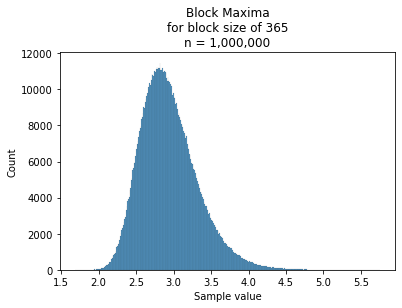

In [4]:
# Plot a histogram of the block maxima
ax = sns.histplot(block_maxima_source)
ax.set_title(
    f"Block Maxima\nfor block size of {block_size}\n"
    +f"n = {len(block_maxima_source):,.0f}"
)
ax.set_xlabel("Sample value")
None # Don't return a value

In [5]:
# Calculate the "true" value for a specified return period
return_period = 100
true_value = np.quantile(block_maxima_source, 1-(1/return_period))
print(f"The 'true' maximum value for a 1-in-{return_period} event is {true_value}")

The 'true' maximum value for a 1-in-100 event is 4.0340823012972695


In [6]:
# If we fit a GEV distribution to the block maxima, this gives us an indication of the 
# precision of our "true" value
params = scipy.stats.genextreme.fit(block_maxima_source)
true_value_fitted = scipy.stats.genextreme.ppf(1-(1/return_period), *params)
print(
    f"From a GEV fit of the source dataset, the maximum value for a\n"
    +f"1-in-{return_period} event is {true_value_fitted}.\n"
    +f"This value differs from the 'true' value by "
    +f"{abs(true_value_fitted-true_value)/true_value*100:.3f}%."
)

From a GEV fit of the source dataset, the maximum value for a
1-in-100 event is 4.0269654852151024.
This value differs from the 'true' value by 0.176%.


## Select a Sample from the Source

We next sample from the "source" distribution.  This is where we'd normally start with a GEV analysis; we wouldn't know the true value so our objective would be to produce confidence intervals that help us understand where the true value might lie.

In [7]:
# Select a sample from the "source" block maxima.
def select_sample(size):
    return rng.choice(block_maxima_source, size=size)

block_maxima_sample = select_sample(100)

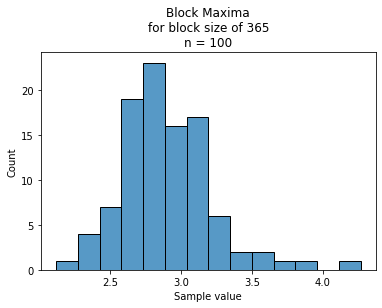

In [8]:
# Plot a histogram of the selected block maxima
ax = sns.histplot(block_maxima_sample)
ax.set_title(
    f"Block Maxima\nfor block size of {block_size}\n"
    +f"n = {len(block_maxima_sample)}"
)
ax.set_xlabel("Sample value")
None # Don't return a value

## GEV Fit

Given the sampled block maxima, we now execute a GEV fit.

In [9]:
# Fit a GEV distribution to the block maxima
params_sample = scipy.stats.genextreme.fit(block_maxima_sample)

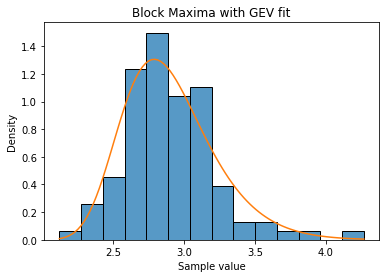

In [10]:
# Plot a histogram of the block maxima
ax = sns.histplot(block_maxima_sample, stat="density")

# Plot the fitted GEV curve
x = np.linspace(
    np.min(block_maxima_sample),
    np.max(block_maxima_sample), 
    100
)
y = scipy.stats.genextreme.pdf(x, *params_sample)
line_color = [sns.color_palette(n_colors=2, as_cmap=True)[1]]
sns.lineplot(x=x, y=y, hue=0, palette=line_color, legend=False)

ax.set_title("Block Maxima with GEV fit")
ax.set_xlabel("Sample value")
None # Don't return a value

## Bootstrap

The GEV fit we produced above is our best estimate of the distribution of the extreme values for this dataset.  We will now use that GEV fit to generate random values from that distribution.  These random values are examples of the values that we could have had, had we not sampled the values that we did.  We'll then produce new GEV fits for these new samples.  Repeating this process many times gives us an idea of how much confidence we should have in our original GEV fit.  This parametric bootstrap method is recommended in Kyselý, 2008.

In [11]:
# Perform a bootstrap, but sample from the fitted distribution
# rather than resampling from the "source" block maxima.
def bootstrap_fits(num_fits, n_original, params_original, display_progress=True):
    fits = []
    for i in range(num_fits):
        # Generate a new sample from the GEV fit of the original sample
        block_maxima_generated = scipy.stats.genextreme.rvs(*params_original, size=n_original)
        # Create a new GEV fit for the new sample
        params = scipy.stats.genextreme.fit(block_maxima_generated)
        # Save the new GEV fit
        fits.append(params)
        # Update the user with progress if desired
        if display_progress:
            print(f"Processed {(i+1)/num_fits*100:.0f}%...", end="\r")

    # Return cursor to new line
    if display_progress:
        print("")
    
    return fits

In [12]:
%%time
# Execute the bootstrap
fits = bootstrap_fits(
    num_fits=100, 
    n_original=len(block_maxima_sample),
    params_original=params_sample
)

Processed 100%...
CPU times: user 2.65 s, sys: 13.4 ms, total: 2.67 s
Wall time: 2.66 s


CPU times: user 905 ms, sys: 130 ms, total: 1.04 s
Wall time: 892 ms


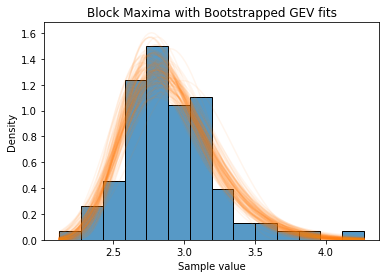

In [13]:
%%time
# Plot a histogram of the block maxima
ax = sns.histplot(block_maxima_sample, stat="density")

# Plot the fitted GEV curves
x = np.linspace(
    np.min(block_maxima_sample),
    np.max(block_maxima_sample), 
    100
)
line_color = [sns.color_palette(n_colors=2, as_cmap=True)[1]]
for params in fits:
    y = scipy.stats.genextreme.pdf(x, *params)
    sns.lineplot(x=x, y=y, hue=0, palette=line_color, legend=False, alpha=1/len(fits)*7)

ax.set_title("Block Maxima with Bootstrapped GEV fits")
ax.set_xlabel("Sample value")
None # Don't return a value

## Return-Period Plot

Given the many GEV fits above, we can also display them on a return-period plot (see part one of this series for more detail).

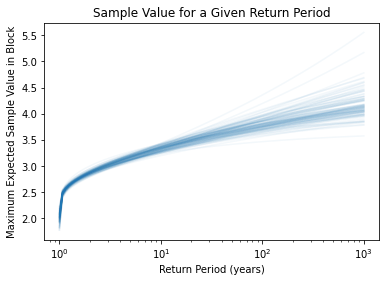

In [14]:
# The value 10^0=1 may not be well defined, so we start with a value slightly larger than that.
return_periods = np.logspace(0.00001, 3, 100)
y_values = 1-(1/return_periods)

line_color = [sns.color_palette(n_colors=1, as_cmap=True)[0]]
for params in fits:
    event_sizes = scipy.stats.genextreme.ppf(y_values, *params)

    ax = sns.lineplot(
        x=return_periods, y=event_sizes, 
        palette=line_color, hue=0, alpha=(1/len(fits))*5,
        legend=False
    )
    # Set the scale of the x-axis

ax.set(xscale="log")
ax.set_title("Sample Value for a Given Return Period") 
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Maximum Expected Sample Value in Block")
None # Don't return a value

## Return-Period Plot with Confidence Intervals

It might be difficult to interpret the semi-opaque GEV curves in the previous plot.  Instead, we may be interested in, say, a 95% confidence interval.  To generate such an interval we need only obtain the 2.5% and 97.5% quantiles for each return period (the difference between those two quantiles is 95%).

To generate confidence intervals, a bootstrap of 1,000 or 10,000 samples would be recommended.

In [15]:
%%time
# Execute the bootstrap with a larger number of samples
fits = bootstrap_fits(
    num_fits=1000, 
    n_original=len(block_maxima_sample),
    params_original=params_sample
)

Processed 100%...
CPU times: user 26.4 s, sys: 98.3 ms, total: 26.5 s
Wall time: 26.5 s


In [16]:
# Calculate the maximum value expected for a range of return periods
return_periods = np.logspace(0.00001, 3, 100)
y_values = 1-(1/return_periods)

event_sizes_list = []
for params in fits:
    event_sizes = scipy.stats.genextreme.ppf(y_values, *params)
    event_sizes_list.append(event_sizes)

In [17]:
# Find the confidence intervals for each return period
alpha = 0.05 # Set this to the desired non-coverage rate (so, 5% for a 95% coverage)
confidence_intervals = np.quantile(event_sizes_list, [alpha/2, 1-alpha/2], axis=0)

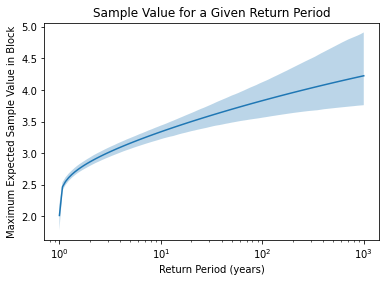

In [18]:
# Plot the original GEV fit
event_sizes = scipy.stats.genextreme.ppf(y_values, *params_sample)
ax = sns.lineplot(
    x=return_periods, y=event_sizes, 
    legend=False
)

# Plot the confidence intervals
plt.fill_between(return_periods, confidence_intervals[0], confidence_intervals[1], alpha=.3)

# Set the plot's attributes
ax.set(xscale="log")
ax.set_title("Sample Value for a Given Return Period") 
ax.set_xlabel("Return Period (years)")
ax.set_ylabel("Maximum Expected Sample Value in Block")

None # Don't return a value

## Did the Confidence Intervals Include the True Value?

At the start of this tutorial we calculated the true value for a specified return period.  Did our confidence interval include this value?

In [19]:
# The "true" value, calculated above.
print(f"The 'true' maximum value for a 1-in-{return_period} event is {true_value}")

The 'true' maximum value for a 1-in-100 event is 4.0340823012972695


In [20]:
# Compare the "true" value with the distribution of the bootstrapped GEVs
values = []
for params in fits:
    value = scipy.stats.genextreme.ppf(1-(1/return_period), *params)
    values.append(value)

In [21]:
def generate_confidence_interval(values, alpha):
    return np.quantile(
        values,
        [alpha/2, 1-alpha/2]
    )

ci = generate_confidence_interval(values, alpha=0.05)
print(
    f"The {(1-alpha)*100:.0f}% confidence interval for a 1-in-{return_period} event is: {ci}"
)

The 95% confidence interval for a 1-in-100 event is: [3.56159505 4.12175866]


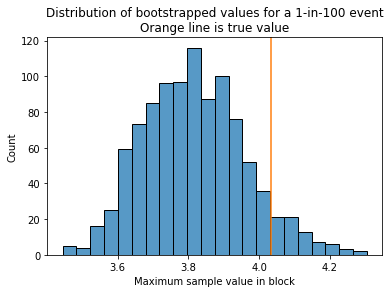

In [22]:
# Plot the distribution of values for a given return period
ax = sns.histplot(values)
line_color = sns.color_palette(n_colors=2, as_cmap=True)[1]
ax.axvline(x=true_value, color=line_color)
ax.set_title(
    f"Distribution of bootstrapped values for a 1-in-{return_period} event\n"
    +f"Orange line is true value"
)
ax.set_xlabel("Maximum sample value in block")
None # don't return a value

## Coverage

Even if the confidence interval above included the true value, that's not enough evidence to say that the methodology works.  Instead, we should calculate the coverage rate.  Unfortunately, this is a very time consuming process as we would typically want to run this for multiple scenarios, where each scenario should have perhaps 10,000 simulations, and where each simulation involves perhaps 10,000 bootstrap samples.

Fortunately, we can rely on the work done by Kyselý showing this method to be acceptable.  Even if the method isn't perfect, it's much better than not providing confidence intervals at all!

Below we demonstrate the process of calculating the coverage for:
* one scenario (a return period of 75 years, where 100 samples are obtained per scenario from our "source" distribution, and 95% confidence intervals are generated),
* for 20 simulations
* where each simulation involves 1,000 bootstrap samples

In [23]:
%%time
# Scenario
return_period = 75
sample_size = 100
alpha = 0.05

# Simulations
num_sims = 20

# Bootstrap samples
num_fits = 1000

results = []
for i in range(num_sims):
    # Select a sample of the "source" block maxima
    block_maxima_sample = select_sample(sample_size)
    
    # Fit a GEV distribution to the sampled block maxima 
    params_sample = scipy.stats.genextreme.fit(block_maxima_sample)
    
    # Bootstrap
    fits = bootstrap_fits(
        num_fits=num_fits, 
        n_original=len(block_maxima_sample),
        params_original=params_sample,
        display_progress=False
    )
    
    # Produce values for given return period
    values = []
    for params in fits:
        value = scipy.stats.genextreme.ppf(1-(1/return_period), *params)
        values.append(value)
        
    # Produce confidence interval
    ci = generate_confidence_interval(values, alpha)
 
    # Test if confidence interval includes the true value
    result = (
        ci[0] <= true_value 
        and ci[1] >= true_value
    )
    
    results.append(result)
    
    print(f"Processed {(i+1)/num_sims*100:.0f}%...", end="\r")

print(
    f"Coverage result: {np.mean(results)*100:.1f}% (expected {(1-alpha)*100:.1f}%)")

Coverage result: 80.0% (expected 95.0%)
CPU times: user 8min 35s, sys: 38 ms, total: 8min 35s
Wall time: 8min 35s


## TL;DR

A GEV analysis with confidence intervals requires that you:

1. Obtain your data.

2. Calculate the block maxima.

3. Fit the GEV curve using `scipy.stats.genextreme.fit()`.

You can then use the following function to create a return period plot with confidence intervals.

Processed 100%...


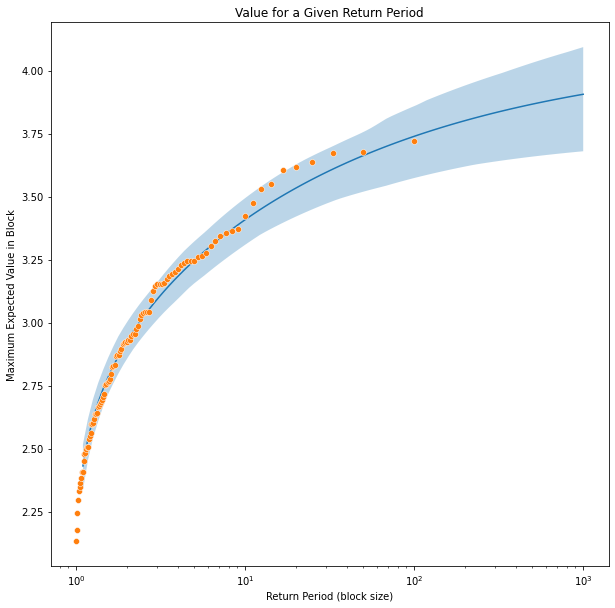

In [24]:
def return_period_plot_with_cis(gev_params, block_maxima, alpha=0.05,
                                return_period_range=None, plot_observed=True,
                                bootstrap_samples=1000):
    """ Produces a return-period plot with confidence intervals given a GEV fit.
    
    Args:
        gev_params: a tuple giving the shape, location, and scale of the GEV fit.
        block_maxima: a list-like containing the maximum values for the blocks used for the GEV fit.
        alpha: likelihood that the true population parameter lies outside the confidence interval
        return_period_range: a two-item tuple or list containing the minimum and maximum values
          for the x-axis.
        plot_observed: a boolean indicating whether to plot the observed values (block_maxima).
        bootstrap_samples: number of bootstrap samples to execute when calculating the confidence
          intervals.
        
    Returns:
        A matplotlib axes for the plot.
    
    """
    # Obtain the range of return periods (x-axis range)
    if return_period_range is not None:
        return_period_lower = return_period_range[0]
        return_period_upper = return_period_range[1]
    else:
        return_period_lower = 1/len(block_maxima)
        return_period_upper = len(block_maxima)
        
    # Calculate the x-values to use (return periods)
    return_periods = np.logspace(
        np.log10(return_period_lower), 
        np.log10(return_period_upper),
        num=100
    )

    # Get points from GEV fit
    probabilities = 1-(1/return_periods)
    event_sizes = scipy.stats.genextreme.ppf(probabilities, *gev_params)
        
    # Plot the GEV fit
    ax = sns.lineplot(
        x=return_periods, 
        y=event_sizes, 
        zorder=0
    )

    # Execute the bootstrap
    fits = bootstrap_fits(
        num_fits=bootstrap_samples, 
        n_original=len(block_maxima),
        params_original=params_sample
    )

    # Calculate the event sizes for all the specified return periods for all GEV fits
    y_values = 1-(1/return_periods)
    event_sizes_list = []
    for params in fits:
        event_sizes = scipy.stats.genextreme.ppf(y_values, *params)
        event_sizes_list.append(event_sizes)
        
    # Find the confidence intervals for each return period
    confidence_intervals = np.quantile(event_sizes_list, [alpha/2, 1-alpha/2], axis=0)

    # Plot the confidence intervals
    plt.fill_between(return_periods, confidence_intervals[0], confidence_intervals[1], alpha=.3)
    
    # Plot the observed block maxima
    if plot_observed:
        # Sort the block maxima
        block_maxima_sorted = sorted(block_maxima)

        # Calculate the proportion of samples at or above the given block maxima
        proportion_at_or_above = np.arange(len(block_maxima), 0, step=-1) / len(block_maxima)

        # Calculate the observed return periods
        return_periods_observed = 1/proportion_at_or_above

        # Plot the observed block maxima
        sns.scatterplot(
            x=return_periods_observed, 
            y=block_maxima_sorted
        )    
    
    # Set the plot's attributes
    ax.set(xscale="log")
    ax.set_title("Value for a Given Return Period") 
    ax.set_xlabel("Return Period (block size)")
    ax.set_ylabel("Maximum Expected Value in Block")
    return ax
    
plt.figure(figsize=(10,10))
ax = return_period_plot_with_cis(
    params_sample, 
    block_maxima_sample,
    return_period_range=[1.1,1000],
    plot_observed=True,
    bootstrap_samples=100
)